# **Exercise 03 - CNN**
### Laboratory of **Computational Physics**, module B
#### University of **Padua** *AY 2021/2022* 

### Group **02**
#### *Students:* Barone Francesco Pio, Nagaro Quiroz Gianmarco, Ninni Daniele, Valentini Lorenzo

***

In this notebook:

1) [More time series in parallel](#exr1)
2) [CNN performance by varying the signal-to-noise ratio](#exr2)
    - [Results](#exr2_results)
3) [Regularization](#exr3)
    - [Grid search](#exr3_ans0)
    - [Values of lambda and regularization](#exr3_ans1)
    - [Weights visualization](#exr3_ans2)
4) [Testing another model](#exr4)
    - [Results](#exr4_ans)
***

In [1]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
%run plot.py  # <- Note: this file has been changed w.r.t. the original one!

# random seed for reproducibility
np.random.seed(12345)

<a id='exr1'></a>
## **1** - More time series in parallel

**Function for the pattern**

Define a pattern which will be summed to part of a time series, over $z$ bins, with amplitude $a$.

In [2]:
def pattern(i,z,a):
    return int(a*np.sin((np.pi*i)/z))

**Create a dataset of arbitrary dimension D**

The following functions create a dataset with dim parallel strains. In each block of 60 elements, the same pattern is summed with a small random shift for all the strains.

In [3]:
def create_strain(N=10000,L=60,DX=50,bias=5,reshape=True):
    jumps = np.random.normal(bias,DX,size=(N*L))
    jumps_int = np.rint(jumps)  # round to int to mimic discrete values from detector
    jumps_int[0] = 0            # set the first element to zero
    x = np.cumsum(jumps_int)    # cumulative sum
    if reshape:
        x = x.reshape((N,L))
    return x

def create_dataset(dim,Z=12,A=500,N=10000,L=60,DX=50,bias=5):
    strains = []
    for i in range(dim):
        strains.append(create_strain(N=N,L=L,DX=DX,bias=bias,reshape=False))

    this = np.dstack(tuple(strains))[0]
    x = this.reshape((N,L,dim))
    
    y = np.zeros(N)
    for i in range(N):
        y[i] = i%3
        if y[i] > 0:
            max_shift = 4
            j0 = np.random.randint(0,L-1-Z-max_shift*(dim-1))  # base point
            j_steps = np.random.randint(0,max_shift,size=(dim-1))  # other shifts
            if dim > 2:
                j_steps = np.cumsum(j_steps)
            
            sign = 3-2*y[i]
            patt = np.zeros(Z)
            for j in range(Z):  # generating the pattern, once for all
                patt[j] = sign*pattern(j,Z,A)  # this is not vectorial, so I must use a for loop
            
            # inject the patterns
            x[i][j0:j0+Z].T[0] += patt
            for count,js in enumerate(j_steps):
                x[i][j0+js:j0+Z+js].T[count+1] += patt
    return x, y

**Example**: we can create a dataset of dimension 4...

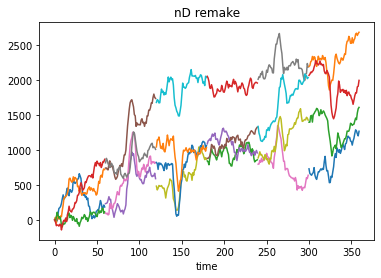

In [4]:
param = {'dim':4, 'Z':12, 'A':500, 'N':10000, 'L':60, 'DX':50, 'bias':5}

x,y = create_dataset(**param)
Show_data(x,60,"nD remake",nsegments=6)  # <- this function has been changed w.r.t. the original one!

...however we will work only with a dataset of 2 parallel strains.

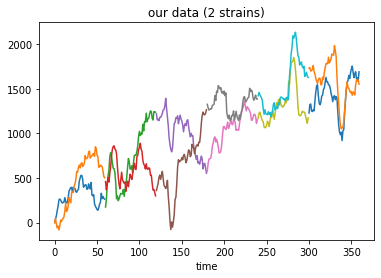

In [5]:
param = {'dim':2, 'Z':12, 'A':500, 'N':10000, 'L':60, 'DX':50, 'bias':5}

x,y = create_dataset(**param)
Show_data(x,60,"our data (2 strains)",nsegments=6)  # <- this function has been changed w.r.t. the original one!

In [6]:
# this function takes the dictionary elements and stores them to variables
locals().update(param)
print(f'For example, N is {N}')

For example, N is 10000


### Define function that saves data on file 

In [7]:
#  WARNING: need a function to save the 3D array! maybe it is better to convert it to 2D: x.reshape((N*L,dim)) 
#           and then reshape back when you want to use it  -> .reshape((N,L,dim))

def saver(x,y,dim=2,Z=12,A=500,N=10000,L=60,DX=50,bias=5):
    !mkdir DATA -p
    str0 = f'ts_L{L}_Z{Z}_A{A}_DX{DX}_bias{bias}_N{N}.dat'
    print('Saving', str0, '...')

    xr = x.reshape((N*L,dim))  # when you read it back, use .reshape((N,L,dim))
    
    fnamex='DATA/x_'+str0
    np.savetxt(fnamex,xr,fmt="%d")
    fnamey='DATA/y_'+str0
    np.savetxt(fnamey,y,fmt="%d")
    print('Done!\n')
    return

### Save data on file

In [8]:
saver(x,y,**param)

Saving ts_L60_Z12_A500_DX50_bias5_N10000.dat ...
Done!



### Check that we do not mess up with the data shape when saving

To test that the data is correctly interpreted when imported, we read a file of the dataset and plot again the strains. If the following plot matches with the plot above, we are confident that data has been imported without any error.

600000 2


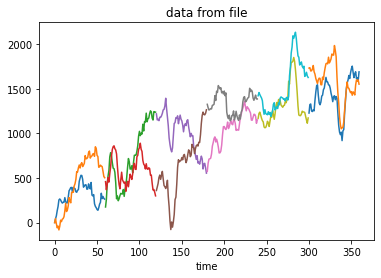

In [9]:
str0 = 'ts_L60_Z12_A500_DX50_bias5_N10000.dat'
fnamex = 'DATA/x_'+str0

param = {'dim':2, 'Z':12, 'A':500, 'N':10000, 'L':60, 'DX':50, 'bias':5}
locals().update(param)

x = np.loadtxt(fnamex,delimiter=" ",dtype=float)
print(len(x),len(x[0]))
x = x.reshape((N,L,dim))  # do this when you read the data!

Show_data(x,L,"data from file",nsegments=6)

### Create the dataset for point 2

In this section we generate a dataset for each amplitude, starting from 50 to 1000 with steps of 50 units. The data generated in this section will be used to test different signal-to-noise ratios in point 2, as well as the other sections of this notebook.

In [10]:
# random seed for reproducibility
np.random.seed(12345)

amplitudes = range(50,1001,50)
for ampl in amplitudes:
    param = {'dim':2, 'Z':12, 'A':ampl, 'N':10000, 'L':60, 'DX':50, 'bias':5}
    locals().update(param)
    
    x,y = create_dataset(**param)
    x = x.reshape((N*L,dim))
    
    saver(x,y,**param)

Saving ts_L60_Z12_A50_DX50_bias5_N10000.dat ...
Done!

Saving ts_L60_Z12_A100_DX50_bias5_N10000.dat ...
Done!

Saving ts_L60_Z12_A150_DX50_bias5_N10000.dat ...
Done!

Saving ts_L60_Z12_A200_DX50_bias5_N10000.dat ...
Done!

Saving ts_L60_Z12_A250_DX50_bias5_N10000.dat ...
Done!

Saving ts_L60_Z12_A300_DX50_bias5_N10000.dat ...
Done!

Saving ts_L60_Z12_A350_DX50_bias5_N10000.dat ...
Done!

Saving ts_L60_Z12_A400_DX50_bias5_N10000.dat ...
Done!

Saving ts_L60_Z12_A450_DX50_bias5_N10000.dat ...
Done!

Saving ts_L60_Z12_A500_DX50_bias5_N10000.dat ...
Done!

Saving ts_L60_Z12_A550_DX50_bias5_N10000.dat ...
Done!

Saving ts_L60_Z12_A600_DX50_bias5_N10000.dat ...
Done!

Saving ts_L60_Z12_A650_DX50_bias5_N10000.dat ...
Done!

Saving ts_L60_Z12_A700_DX50_bias5_N10000.dat ...
Done!

Saving ts_L60_Z12_A750_DX50_bias5_N10000.dat ...
Done!

Saving ts_L60_Z12_A800_DX50_bias5_N10000.dat ...
Done!

Saving ts_L60_Z12_A850_DX50_bias5_N10000.dat ...
Done!

Saving ts_L60_Z12_A900_DX50_bias5_N10000.dat ...


<a id='exr2'></a>
## **2** - CNN performance by varying the signal-to-noise ratio

In [ ]:
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten #, Reshape
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D

### Define function that reads data from file

In [ ]:
def reader(plot=True,dim=2,Z=12,A=500,N=10000,L=60,DX=50,bias=5):
    str0 = f'ts_L{L}_Z{Z}_A{A}_DX{DX}_bias{bias}_N{N}.dat'
    print('Reading',str0,'...')
    fnamex = 'DATA/x_'+str0
    fnamey = 'DATA/y_'+str0

    x = np.loadtxt(fnamex,delimiter=" ",dtype=float)
    x = x.reshape((N,L,dim))
    if plot == True:
        Show_data(x,L,"data from file",nsegments=6)

    categ = np.loadtxt(fnamey,dtype=int)
    n_class = 3 # y.argmax()-y.argmin()+1
    y = np.zeros((N,n_class))
    for i in range(N):
        y[i][categ[i]] = 1.

    print('Done!')
    return x,y,n_class

### Define function that rescales data and splits it into training set and validation set

In [ ]:
def data_preprocess(x,y,n_class,plot=True,dim=2,Z=12,A=500,N=10000,L=60,DX=50,bias=5):
    # FIRST PASSAGE: DO NOT DO THIS --> FAILURE 
    #
    # remove average value of each sample from its values
    xm = x.mean(axis=1)
    for i in range(N):
        x[i] = x[i]-xm[i]

    # SECOND PASSAGE: DO NOT DO THIS --> ALSO FAILURE 
    #
    # rescale (crude version, variance should be used)
    x = x/400
        
    if plot == True:    
        Show_data(x,L,"rescaled data",nsegments=6)

    perc_train = 0.8
    N_train = int(perc_train*N)
    x_train = x[:N_train]
    y_train = y[:N_train]
    x_val = x[N_train:]
    y_val = y[N_train:]
    N_val = len(x_val)
    #print(f'A={A}, N_train={N_train}, N_val={N_val}, L={L}, n_class={n_class}')

    #x_train = x_train.astype("float32")
    #y_train = y_train.astype("float32")
    #x_val = x_val.astype("float32")
    #y_val = y_val.astype("float32")

    x_train = x_train.reshape(x_train.shape[0],L,dim)
    x_val =  x_val.reshape(x_val.shape[0],L,dim)

    return x_train,y_train,x_val,y_val

### Compile CNN model

In [ ]:
param = {'dim':2, 'Z':12, 'A':500, 'N':10000, 'L':60, 'DX':50, 'bias':5}
locals().update(param)

input_shape = (L,dim)
n_class = 3

# ...LESSON...
# reproducibility
np.random.seed(12345)
import tensorflow.random as tf_r
tf_r.set_seed(12345)

# from keras import regularizers, initializers

reg = tf.keras.regularizers.l2(0.2) # raised to 0.2
#reg = regularizers.l1(0.1)
ini = tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.05,seed=None)
NCONV = 1
NF = 5

# challenge: at most 600 tunable parameters
model = Sequential()
# 
if NCONV == 1:
    # -----1-----
    model.add(Conv1D(filters=NF,
                     kernel_size=11, 
                     kernel_initializer=ini, 
                     kernel_regularizer=reg,
                     activation='relu', 
                     input_shape=input_shape))
    #model.add(MaxPooling1D(3))
    model.add(AveragePooling1D(5))
    model.add(Conv1D(filters=5,
                     kernel_size=7, 
                     activation='relu'))
    model.add(Flatten())
    model.add(Dense(12,activation='relu'))
    model.add(Dropout(0.2))
# 
if NCONV == 2:
    # -----2-----
    model.add(Conv1D(filters=NF,
                     kernel_size=11, 
                     kernel_initializer=ini, 
                     kernel_regularizer=reg, # TRY WITHOUT!
                     activation='relu',
                     input_shape=input_shape))
    #model.add(MaxPooling1D(3))
    model.add(AveragePooling1D(5))
    model.add(Flatten())
    model.add(Dense(9,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(6,activation='relu'))
    model.add(Dropout(0.2))
    #model.add(Dense(10,activation='relu'))
    #model.add(Dropout(0.3))
model.add(Dense(n_class,activation='softmax')) # softmax!

print('----- Model',NCONV,'-----')
print(model.summary())

# optimizers
# .SGD(lr=0.01,momentum=0.9,nesterov=True) # decay=1e-6
# .RMSprop()
# .Nadam()
opt = tf.keras.optimizers.Adam()

# compile the model
# categorical_crossentropy, 3 output nodes
model.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt,metrics=['accuracy'])

----- Model 1 -----
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 5)             115       
                                                                 
 average_pooling1d (AverageP  (None, 10, 5)            0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 4, 5)              180       
                                                                 
 flatten (Flatten)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 12)                252       
                                                                 
 dropout (Dropout)           (None, 12)                0         
                                    

In [ ]:
model.layers

### Define function that plots weights

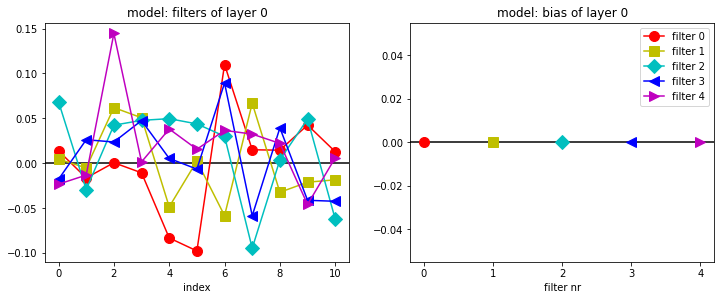

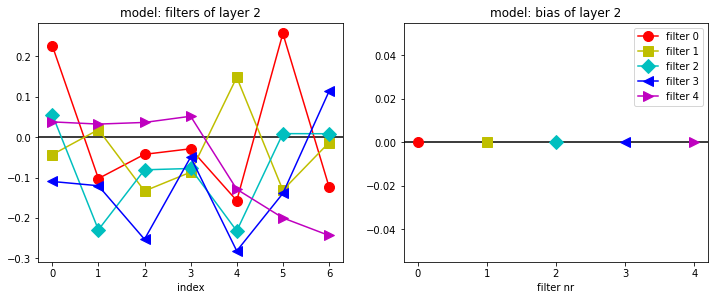

In [ ]:
def Show_weights(model,l=0,label="model"):
    c = ['r','y','c','b','m']
    m = ['o','s','D','<','>']
    ms = 10
    
    w = model.layers[l].get_weights()[0]
    wT = w.T
    M = len(wT)
    b = model.layers[l].get_weights()[1]
    
    fig,AX = plt.subplots(1,2,figsize=(12,4.4))
    ax = AX[0]
    ax.axhline(0,c="k")
    ax.plot((0,))
    for i in range(M):
        ax.plot(wT[i][0],"-",c=c[i],marker=m[i],label=str(i),markersize=ms)
    ax.set_title(label+': filters of layer '+str(l))
    ax.set_xlabel('index')
    ax = AX[1]
    ax.axhline(0,c="k")
    for i in range(M):
        ax.plot((i),(b[i]),c=c[i],marker=m[i],label="filter "+str(i),markersize=ms)
    ax.set_title(label+': bias of layer '+str(l))
    ax.set_xlabel('filter nr')
    ax.set_xticks(np.arange(5))
    ax.legend()
    plt.show()
    
Show_weights(model,0)
Show_weights(model,2)

### Train the CNN using data corresponding to various amplitudes

In [ ]:
# ...LESSON...
# Hyper-parameters
# with small minibatch it does not converge!
BATCH_SIZE = 250
EPOCHS = 100

train_acc,val_acc = [],[]
amplitudes = range(50,1001,50)
for ampl in amplitudes:

    param = {'dim':2, 'Z':12, 'A':ampl, 'N':10000, 'L':60, 'DX':50, 'bias':5}
    x,y,n_class = reader(plot=False,**param)
    x_train,y_train,x_val,y_val = data_preprocess(x,y,n_class,plot=False,**param)

    print('----- Model',NCONV,'-----\nFITTING ...')
    fit = model.fit(x_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(x_val,y_val),
                    verbose=0,
                    shuffle=True)
    train_acc.append(fit.history['accuracy'][-1])
    val_acc.append(fit.history['val_accuracy'][-1])

    print('DONE!\n')

Reading ts_L60_Z12_A50_DX50_bias5_N10000.dat ...
Done!
----- Model 1 -----
FITTING ...
DONE!

Reading ts_L60_Z12_A100_DX50_bias5_N10000.dat ...
Done!
----- Model 1 -----
FITTING ...
DONE!

Reading ts_L60_Z12_A150_DX50_bias5_N10000.dat ...
Done!
----- Model 1 -----
FITTING ...
DONE!

Reading ts_L60_Z12_A200_DX50_bias5_N10000.dat ...
Done!
----- Model 1 -----
FITTING ...
DONE!

Reading ts_L60_Z12_A250_DX50_bias5_N10000.dat ...
Done!
----- Model 1 -----
FITTING ...
DONE!

Reading ts_L60_Z12_A300_DX50_bias5_N10000.dat ...
Done!
----- Model 1 -----
FITTING ...
DONE!

Reading ts_L60_Z12_A350_DX50_bias5_N10000.dat ...
Done!
----- Model 1 -----
FITTING ...
DONE!

Reading ts_L60_Z12_A400_DX50_bias5_N10000.dat ...
Done!
----- Model 1 -----
FITTING ...
DONE!

Reading ts_L60_Z12_A450_DX50_bias5_N10000.dat ...
Done!
----- Model 1 -----
FITTING ...
DONE!

Reading ts_L60_Z12_A500_DX50_bias5_N10000.dat ...
Done!
----- Model 1 -----
FITTING ...
DONE!

Reading ts_L60_Z12_A550_DX50_bias5_N10000.dat ...
D

<a id='exr2_results'></a>
### Results for various amplitudes (SNR)

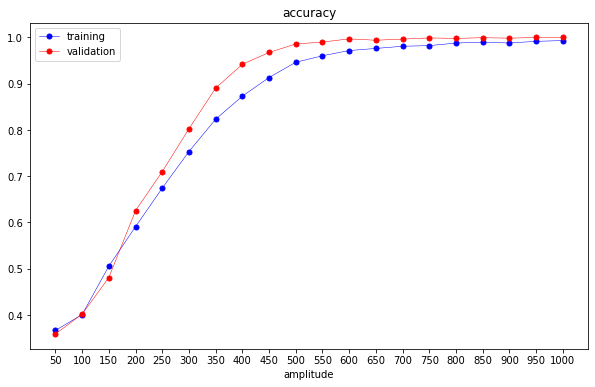

In [ ]:
fig,ax = plt.subplots(figsize=(10,6))
ax.plot(amplitudes, train_acc, linewidth=.5, color='blue', marker='o', markersize=5, label='training')
ax.plot(amplitudes, val_acc,   linewidth=.5, color='red',  marker='o', markersize=5, label='validation')
ax.set_xticks(amplitudes)
ax.set_xlabel('amplitude')
ax.set_title('accuracy')
ax.legend()
plt.show()

| Amplitude | Training accuracy | Validation accuracy |
| :-: | :-: | :-: |
|   50 | 0.3666 | 0.3590 |
|  100 | 0.4010 | 0.4020 |
|  150 | 0.5056 | 0.4810 |
|  200 | 0.5910 | 0.6255 |
|  250 | 0.6743 | 0.7100 |
|  300 | 0.7534 | 0.8025 |
|  350 | 0.8232 | 0.8905 |
|  400 | 0.8730 | 0.9420 |
|  450 | 0.9134 | 0.9675 |
|  500 | 0.9464 | 0.9860 |
|  550 | 0.9604 | 0.9900 |
|  600 | 0.9718 | 0.9970 |
|  650 | 0.9762 | 0.9940 |
|  700 | 0.9810 | 0.9965 |
|  750 | 0.9824 | 0.9990 |
|  800 | 0.9879 | 0.9980 |
|  850 | 0.9900 | 0.9995 |
|  900 | 0.9880 | 0.9985 |
|  950 | 0.9916 | 1.0000 |
| 1000 | 0.9933 | 1.0000 |

### Define function that shows history of the training process

In [ ]:
def Show_history(fit):
    fig,AX = plt.subplots(1,2,figsize=(12,5.))
    ax = AX[0]
    ax.plot(fit.history['accuracy'],"b",label="train")
    ax.plot(fit.history['val_accuracy'],"r--",label="valid.")
    ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray",label="random choice")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0,1])
    ax.legend()
    ax = AX[1]
    ax.plot(fit.history['loss'],"b",label="train")
    ax.plot(fit.history['val_loss'],"r--",label="valid.")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.set_ylim([0,1.05*np.max(fit.history['loss'])])
    ax.legend()
    plt.show()

### Train the CNN using data corresponding to a particular amplitude

Scroll until the bottom of the cell to see the history of the training process.

Reading ts_L60_Z12_A500_DX50_bias5_N10000.dat ...
Done!
----- Model 1 -----
FITTING ...
Epoch 1/100
32/32 - 0s - loss: 0.1987 - accuracy: 0.9352 - val_loss: 0.0599 - val_accuracy: 0.9820 - 251ms/epoch - 8ms/step
Epoch 2/100
32/32 - 0s - loss: 0.1295 - accuracy: 0.9569 - val_loss: 0.0437 - val_accuracy: 0.9875 - 258ms/epoch - 8ms/step
Epoch 3/100
32/32 - 0s - loss: 0.1051 - accuracy: 0.9644 - val_loss: 0.0460 - val_accuracy: 0.9880 - 258ms/epoch - 8ms/step
Epoch 4/100
32/32 - 0s - loss: 0.1118 - accuracy: 0.9616 - val_loss: 0.0486 - val_accuracy: 0.9875 - 253ms/epoch - 8ms/step
Epoch 5/100
32/32 - 0s - loss: 0.1009 - accuracy: 0.9670 - val_loss: 0.0394 - val_accuracy: 0.9905 - 257ms/epoch - 8ms/step
Epoch 6/100
32/32 - 0s - loss: 0.1004 - accuracy: 0.9674 - val_loss: 0.0409 - val_accuracy: 0.9910 - 245ms/epoch - 8ms/step
Epoch 7/100
32/32 - 0s - loss: 0.1016 - accuracy: 0.9671 - val_loss: 0.0426 - val_accuracy: 0.9885 - 259ms/epoch - 8ms/step
Epoch 8/100
32/32 - 0s - loss: 0.0996 - accu

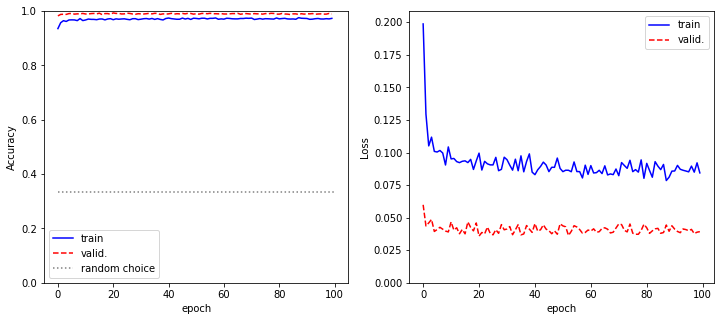

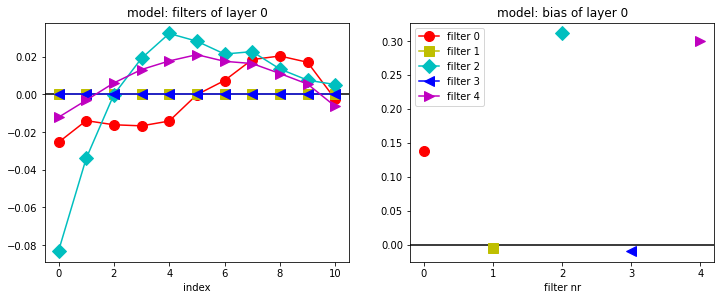

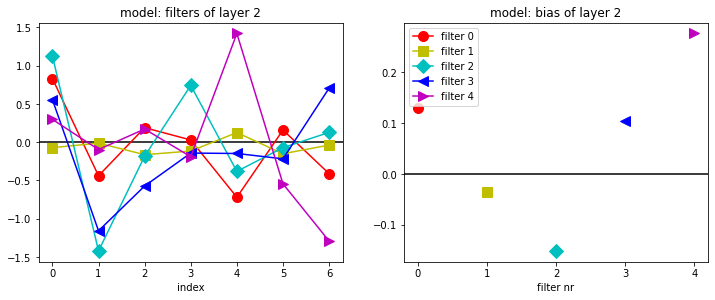

In [ ]:
ampl = 500 # sample amplitude

param = {'dim':2, 'Z':12, 'A':ampl, 'N':10000, 'L':60, 'DX':50, 'bias':5}
x,y,n_class = reader(plot=False,**param)
x_train,y_train,x_val,y_val = data_preprocess(x,y,n_class,plot=False,**param)

print('----- Model',NCONV,'-----\nFITTING ...')
fit = model.fit(x_train,
                y_train,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_val,y_val),
                verbose=2,
                shuffle=True)
print('DONE!\n')

Show_history(fit)
Show_weights(model,0)
Show_weights(model,2)

### Confusion matrix

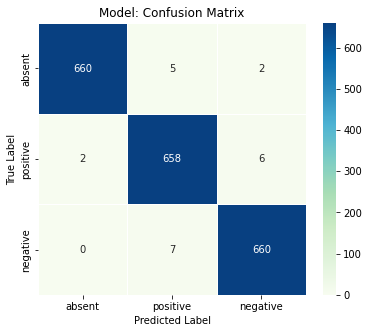

In [ ]:
import seaborn 
from sklearn import metrics

LABELS = ["absent","positive","negative"]
cmap = "GnBu"

def show_confusion_matrix(validations,predictions,label="Model"):
    matrix = metrics.confusion_matrix(validations,predictions)
    plt.figure(figsize=(6,5))
    seaborn.heatmap(matrix,
                    xticklabels=LABELS,
                    yticklabels=LABELS,
                    annot=True,
                    fmt='d',
                    linecolor='white',
                    linewidths=1,
                    cmap=cmap)
    plt.title(label+': Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_val = model.predict(x_val)
# Take the class with the highest probability from the val predictions
max_y_pred_val = np.argmax(y_pred_val,axis=1)
max_y_val = np.argmax(y_val,axis=1)

show_confusion_matrix(max_y_val,max_y_pred_val)

<a id='exr3'></a>
## **3** - Regularization


In [6]:
plt.rcParams['font.size'] = 14

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten #, Reshape
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


### Read data

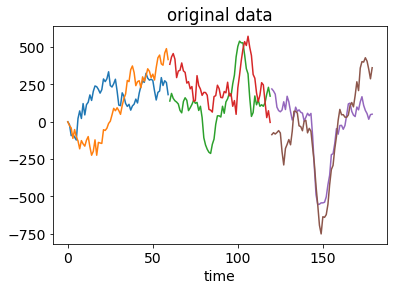

data:  10000


In [7]:
str0 = 'ts_L60_Z12_A500_DX50_bias5_N10000.dat'
fnamex = 'DATA/x_'+str0
fnamey = 'DATA/y_'+str0

x = np.loadtxt(fnamex,delimiter=" ",dtype=float)
param = {'dim':2, 'Z':12, 'A':500, 'N':10000, 'L':60, 'DX':50, 'bias':5}
locals().update(param)
x = x.reshape((N,L,dim))
Show_data(x,L,"original data")

categ = np.loadtxt(fnamey,dtype=int)
n_class = 3 # y.argmax()-y.argmin()+1
print('data: ',N)

y = np.zeros((N,n_class))
for i in range(N):
    y[i][categ[i]] = 1.

### Rescale data, split train/val.

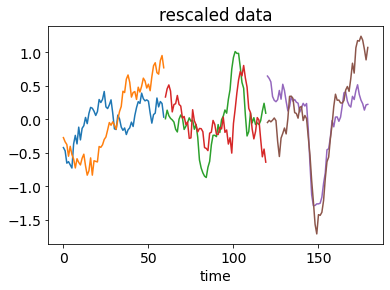

N_train= 8000   N_val= 2000   L= 60   n_class= 3


In [8]:
# FIRST PASSAGE: DO NOT DO THIS --> FAILURE 
#
# remove average value of each sample from its values
xm = x.mean(axis=1)
for i in range(N):
    x[i] = x[i]-xm[i]

# SECOND PASSAGE: DO NOT DO THIS --> ALSO FAILURE 
#
# rescale (crude version, variance should be used)
x = x/400
    
Show_data(x,L,"rescaled data")

perc_train = 0.8
N_train = int(perc_train*N)
x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]
N_val = len(x_val)
print('N_train=',N_train,'  N_val=',N_val,'  L=',L,'  n_class=',n_class)

#x_train = x_train.astype("float32")
#y_train = y_train.astype("float32")
#x_val = x_val.astype("float32")
#y_val = y_val.astype("float32")

x_train = x_train.reshape(x_train.shape[0],L,2)
x_val = x_val.reshape(x_val.shape[0],L,2)
input_shape = (L,2)

### Convolutional NN

In [9]:
# ...LESSON...
# reproducibility
np.random.seed(12345)
import tensorflow.random as tf_r
tf_r.set_seed(12345)

In [10]:
def create_DNN_GridSearch(activation, dropout_rate, reg_lambda, reg_type):
    if reg_type == "Lasso" :
        reg = tf.keras.regularizers.l1(reg_lambda)
    elif reg_type == "Ridge" :
        reg = tf.keras.regularizers.l2(reg_lambda)
    else:
        reg = tf.keras.regularizers.l1_l2(reg_lambda)
    
    NCONV = 1
    NF = 5
    ini = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
    model = Sequential()
    
    model.add(Conv1D(filters=NF, kernel_size=11, 
                     kernel_initializer=ini, 
                     kernel_regularizer=reg,
                     activation="relu", 
                     input_shape=input_shape))
    #model.add(MaxPooling1D(3))
    model.add(AveragePooling1D(5))
    model.add(Conv1D(filters=5, kernel_size=7, 
                     activation=activation))
    model.add(Flatten())
    model.add(Dense(12, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_class, activation="sigmoid"))
    
    return model
    
def compile_model(optimizer="Adam", activation="relu", dropout_rate=0.2, reg_lambda=0.002, reg_type="Lasso"):
    # create the mode
    model = create_DNN_GridSearch(activation, dropout_rate, reg_lambda,reg_type)
    # compile the model
    model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    return model

In [11]:
# call Keras scikit wrapper
model_gridsearch = KerasClassifier(build_fn=compile_model)

# list of allowed optional arguments for the optimizer, see `compile_model()`
optimizer = ["Adam","RMSProp"]
activation = ['relu',"tanh","softplus","softsign"]
dropout_rate = [0.0,0.1,0.2,0.3,0.4]
reg_lambda = [0,2*10**-6,2*10**-5,2*10**-4,2*10**-3,2*10**-2,2*10**-1,2,2*10**1]
reg_type = ["Lasso","Ridge","Combined"]
# define parameter dictionary
param_grid = dict(optimizer=optimizer, activation=activation, dropout_rate=dropout_rate, reg_lambda=reg_lambda, reg_type=reg_type)

In [ ]:
## DO THE GRIDSEARCH

# call scikit grid search module
#grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=-1, cv=4)
#grid_result = grid.fit(x_train,y_train,epochs=200,batch_size=10,shuffle=True,verbose=0) # epochs and batch sizes have to be increased, but we need a powerful computer

In [ ]:
# SUMMARIZE RESULTS

#print("best %f%% using %s" % (grid_result.best_score_, grid_result.best_params_))
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#grid_results_sorted = sorted(zip(means, stds, params), key=lambda x: x[0], reverse=True)

#print('\n======= all results ======')
#for mean, stdev, param in grid_results_sorted: #sorted(grid_results_sorted, key=lambda x: x[2]['optimizer'], reverse=True):
#    print("%f (+-%f) with: %r" % (mean, stdev, param))

In [16]:
## ...OR LOAD THE RESULTS

import json

with open('params.json', 'r') as f:
    params = json.load(f)

means = np.load('means.npy')
stds = np.load('stds.npy')
grid_results_sorted = sorted(zip(means, stds, params), key=lambda x: x[0], reverse=True)

<a id='exr3_ans0'></a>
### Answer 3.0: grid search results

A grid search was conducted with different values of lambda: 
$$
lambda = [0, 2\cdot 10^{-6}, 2\cdot 10^{-5},2\cdot 10^{-4},2\cdot 10^{-3}, 2\cdot 10^{-2}, 2\cdot 10^{-1}, 2]
$$
and 3 different regularization classes:
$$
type = [Lasso, Ridge, Combined]
$$

The best model selected by the grid search has been selected to train a new model.

In [34]:
chosen_params = {'activation':'relu', 'dropout_rate': 0.2, 'optimizer':'Adam', 'reg_lambda':0.02, 'reg_type':'Ridge'} # paste here the model to use

model = compile_model(**chosen_params)
model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer="adam", metrics=['accuracy'])
fit = model.fit(x_train, y_train,
                epochs=400, batch_size=50,
                validation_data=(x_val, y_val),
                verbose=0)

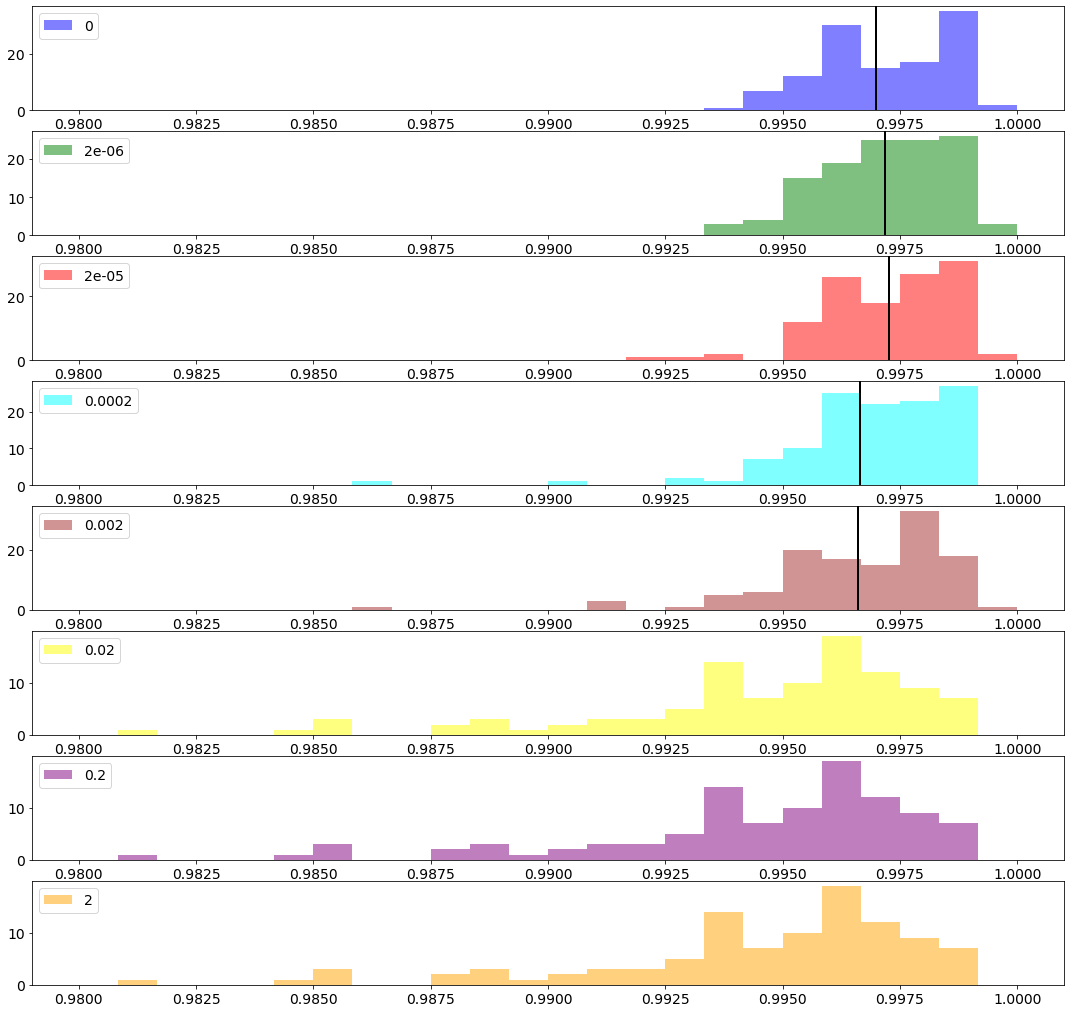

In [26]:
layerscores = [[] for i in range(len(reg_lambda))]

for i in range(len(reg_lambda)):
    layerscores[i] = list(list(zip(*[d for d in grid_results_sorted if d[2]['reg_lambda']==reg_lambda[i]]))[0])

data1 = np.array(layerscores[0])
data2 = np.array(layerscores[1])
data3 = np.array(layerscores[2])
data4 = np.array(layerscores[3])
data5 = np.array(layerscores[4])
data6 = np.array(layerscores[5])
data7 = np.array(layerscores[6])
data8 = np.array(layerscores[7])

fig,(ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7) = plt.subplots(8)
fig.set_size_inches(18.5, 18)
bins = np.linspace(0.98, 1, 25)
ax0.hist(data1, bins=bins, color='blue',   label=str(reg_lambda[0]) ,alpha=0.5, histtype='stepfilled')
ax1.hist(data2, bins=bins, color='green',  label=str(reg_lambda[1]), alpha=0.5, histtype='stepfilled')
ax2.hist(data3, bins=bins, color='red',    label=str(reg_lambda[2]), alpha=0.5, histtype='stepfilled')
ax3.hist(data4, bins=bins, color='cyan',   label=str(reg_lambda[3]), alpha=0.5, histtype='stepfilled')
ax4.hist(data5, bins=bins, color='brown',  label=str(reg_lambda[4]), alpha=0.5, histtype='stepfilled')
ax5.hist(data6, bins=bins, color='yellow', label=str(reg_lambda[5]), alpha=0.5, histtype='stepfilled')
ax6.hist(data6, bins=bins, color='purple', label=str(reg_lambda[6]), alpha=0.5, histtype='stepfilled')
ax7.hist(data6, bins=bins, color='orange', label=str(reg_lambda[7]), alpha=0.5, histtype='stepfilled')

# this lines indicate the means
ax0.axvline(np.nanmean(data1), color='black', linewidth=2)
ax1.axvline(np.nanmean(data2), color='black', linewidth=2)
ax2.axvline(np.nanmean(data3), color='black', linewidth=2)
ax3.axvline(np.nanmean(data4), color='black', linewidth=2)
ax4.axvline(np.nanmean(data5), color='black', linewidth=2)
#ax5.axvline(np.nanmean(data6), color='black', linewidth=2)
#ax6.axvline(np.nanmean(data7), color='black', linewidth=2)
#ax7.axvline(np.nanmean(data8), color='black', linewidth=2)

ax0.legend(loc='upper left')
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
ax4.legend(loc='upper left')
ax5.legend(loc='upper left')
ax6.legend(loc='upper left')
ax7.legend(loc='upper left')

plt.show()

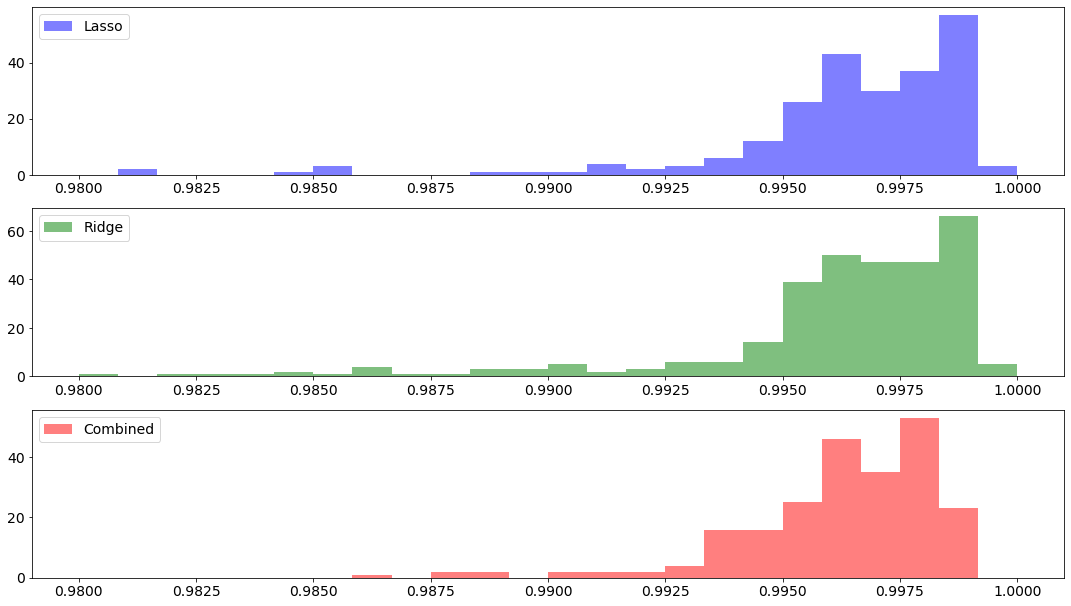

In [23]:
layerscores = [[] for i in range(len(reg_type))]

for i in range(len(reg_type)):
    layerscores[i] = list(list(zip(*[d for d in grid_results_sorted if d[2]['reg_type']==reg_type[i]]))[0])

data1 = np.array(layerscores[0])
data2 = np.array(layerscores[1])
data3 = np.array(layerscores[2])
#data4 = np.array(layerscores[3])
#data5 = np.array(layerscores[4])
#data6 = np.array(layerscores[5])

fig,(ax0,ax1,ax2) = plt.subplots(3)
fig.set_size_inches(18.5, 10.5)
bins = np.linspace(0.98, 1,25)
ax0.hist(data1, bins=bins, color='blue',   label=reg_type[0], alpha=0.5, histtype='stepfilled')
ax1.hist(data2, bins=bins, color='green',  label=reg_type[1], alpha=0.5, histtype='stepfilled')
ax2.hist(data3, bins=bins, color='red',    label=reg_type[2], alpha=0.5, histtype='stepfilled')
#ax.hist(data4, bins=bins, color='cyan',   label='4 Layers',  alpha=0.5, histtype='stepfilled')
#ax.hist(data5, bins=bins, color='brown',  label='5 Layers',  alpha=0.5, histtype='stepfilled')
#ax.hist(data6, bins=bins, color='yellow', label='6 Layers',  alpha=0.5, histtype='stepfilled')

# this lines indicate the means
#ax0.axvline(np.nanmean(data1), color='blue',  linewidth=2)
#ax1.axvline(np.nanmean(data3), color='green', linewidth=2)
#ax2.axvline(np.nanmean(data2), color='red',   linewidth=2)
#ax.axvline(data4.mean(), color='cyan',   linewidth=2)
#ax.axvline(data5.mean(), color='brown',  linewidth=2)
#ax.axvline(data6.mean(), color='yellow', linewidth=2)

ax0.legend(loc='upper left')
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')

plt.show()

<a id='exr3_ans1'></a>
### Answer 3.1: values of lambda and regularizations

|      	| Lasso    	| Ridge    	| Combined 	|   	|
|------	|----------	|----------	|----------	|---	|
| Mean 	| 0.776875 	| 0.957768 	| 0.775256 	|   	|


|   λ   | 0      	| 2e-6    	| 2e-5   	| 2e-4   	| 2e-3   	| 2e-2   	| 2e-1      | 2	        |   	|
|------	|----------	|----------	|----------	|----------	|----------	|----------	|----------	|----------	|---	|
| Mean 	| 0.996988 	| 0.997179 	| 0.997268 	|  0.996639	|  0.996608	|  0.911220	|  0.640497	|  0.522961	|   	|


In the first group of histograms, the black lines represent the mean of the scores found for a given lambda. It can be noted that the bins approaching the left part of the histograms are being occupied in greater amount by the higher regularization lambda. The last values of the means are heavily affected by results that were negatively affected by big regularization and are close to 0.33 (random choice). It can be also noted that Ridge regularization is more resistant to high lambda while Lasso and Combined have their filters put to zero in numerous occasions.

<a id='exr3_ans2'></a>
### Answer 3.2: weights visualization

It can be appreciated, from the following graphs, that some filter coefficients are put to 0 by the regularization procedure. It happens because the network learns to recognize that a concave and a convex shape are being introduced to the data samples.

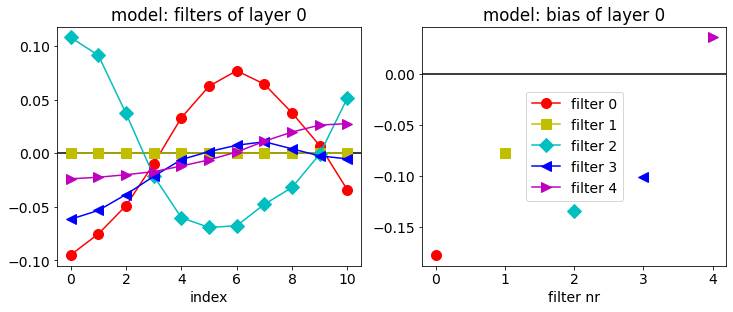

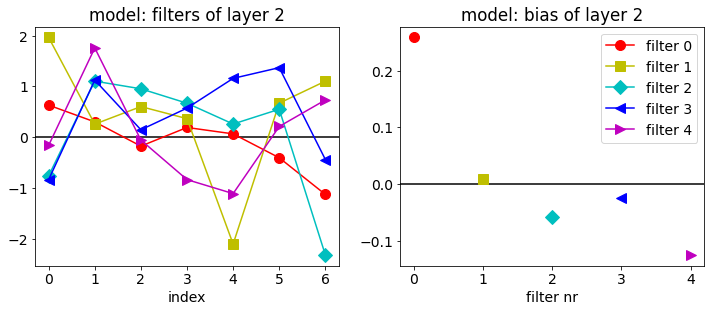

In [36]:
def Show_weights(model,l=0,label="model"):
    c = ['r','y','c','b','m']
    m = ['o','s','D','<','>']
    ms = 10
    
    w = model.layers[l].get_weights()[0]
    wT = w.T
    M = len(wT)
    b = model.layers[l].get_weights()[1]
    
    fig,AX = plt.subplots(1,2,figsize=(12,4.4))
    ax = AX[0]
    ax.axhline(0,c="k")
    ax.plot((0,))
    for i in range(M):
        ax.plot(wT[i][0],"-",c=c[i],marker=m[i],label=str(i),markersize=ms)
    ax.set_title(label+': filters of layer '+str(l))
    ax.set_xlabel('index')
    ax = AX[1]
    ax.axhline(0,c="k")
    for i in range(M):
        ax.plot((i),(b[i]),c=c[i],marker=m[i],label="filter "+str(i),markersize=ms)
    ax.set_title(label+': bias of layer '+str(l))
    ax.set_xlabel('filter nr')
    ax.set_xticks(np.arange(5))
    ax.legend()
    plt.show()
    
Show_weights(model,0)
Show_weights(model,2)

<a id='exr4'></a>
## **4** - Testing another model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, AveragePooling1D
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

### Read data

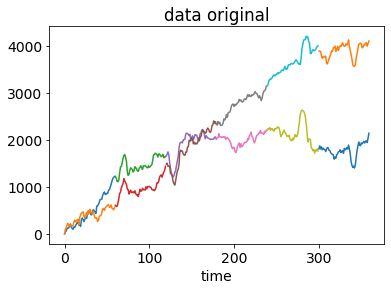

In [ ]:
str0 = f'ts_L60_Z12_A500_DX50_bias5_N10000.dat'
fnamex = 'DATA/x_'+str0
fnamey = 'DATA/y_'+str0

x = np.loadtxt(fnamex,delimiter=" ",dtype=float)
param = {'dim':2, 'Z':12, 'A':500, 'N':10000, 'L':60, 'DX':50, 'bias':5}
locals().update(param)
x = x.reshape((N,L,dim))
Show_data(x,L,"data original",nsegments=6)

categ = np.loadtxt(fnamey,dtype=int)
n_class = 3 # y.argmax()-y.argmin()+1

y = np.zeros((N,n_class))
for i in range(N):
    y[i][categ[i]] = 1.

### Rescale data, split train/val.

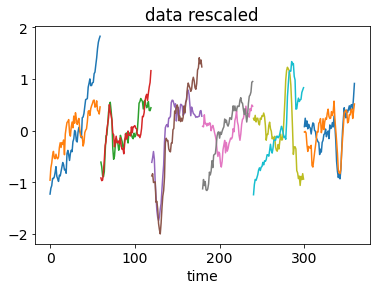

N_train= 8000   N_val= 2000   L= 60   n_class= 3


In [ ]:
# FIRST PASSAGE: DO NOT DO THIS --> FAILURE 
#
# remove average value of each sample from its values
xm = x.mean(axis=1)
for i in range(N):
    x[i] = x[i]-xm[i]

# SECOND PASSAGE: DO NOT DO THIS --> ALSO FAILURE 
#
# rescale (crude version, variance should be used)
x = x/400
    
Show_data(x,L,"data rescaled",nsegments=6)

perc_train = 0.8
N_train = int(perc_train*N)
x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]
N_val = len(x_val)
print('N_train=',N_train,'  N_val=',N_val,'  L=',L,'  n_class=',n_class)

#x_train = x_train.astype("float32")
#y_train = y_train.astype("float32")
#x_val = x_val.astype("float32")
#y_val = y_val.astype("float32")

x_train = x_train.reshape(x_train.shape[0],L,2)
x_val = x_val.reshape(x_val.shape[0],L,2)
input_shape = (L,2)

### CNN model

In [ ]:
np.random.seed(12345)
import tensorflow.random as tf_r
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, AveragePooling1D
tf_r.set_seed(12345)

reg = tf.keras.regularizers.l2(0.2) # raised to 0.2
#reg = regularizers.l1(0.1)
ini = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)

input_shape = (L, 2)
model_best_last_year = Sequential()
model_best_last_year.add(Conv1D(filters=8, kernel_size=3, 
                                kernel_initializer=ini, 
                                kernel_regularizer=reg,
                                activation='relu', 
                                input_shape=input_shape))
model_best_last_year.add(Conv1D(filters=8, kernel_size=9, 
                                activation='sigmoid'))
model_best_last_year.add(Conv1D(filters=4, kernel_size=3, 
                                activation='relu'))
model_best_last_year.add(GlobalMaxPooling1D())
model_best_last_year.add(Flatten())
model_best_last_year.add(Dense(3, activation='softmax'))

print('-------- Global Pooling Model-------')
print(model_best_last_year.summary())

opt = tf.keras.optimizers.Adam()
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False,
                                               label_smoothing=0.0,
                                               axis=-1,
                                               reduction="auto",
                                               name="categorical_crossentropy",)

model_best_last_year.compile(loss=loss, optimizer=opt, metrics=['accuracy'])

-------- Global Pooling Model-------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 58, 8)             56        
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 8)             584       
                                                                 
 conv1d_2 (Conv1D)           (None, 48, 4)             100       
                                                                 
 global_max_pooling1d (Globa  (None, 4)                0         
 lMaxPooling1D)                                                  
                                                                 
 flatten (Flatten)           (None, 4)                 0         
                                                                 
 dense (Dense)               (None, 3)                 15        
                   

In [ ]:
model_best_last_year.layers

In [ ]:
BATCH_SIZE = 100
EPOCHS = 50

print('----- Model ','-----\nFITTING....')
fit = model_best_last_year.fit(x_train, y_train,
                               batch_size=BATCH_SIZE,
                               epochs=EPOCHS,
                               validation_data=(x_val, y_val),
                               verbose=2,
                               shuffle=True) 

----- Model  -----
FITTING....
Epoch 1/50
80/80 - 1s - loss: 1.0971 - accuracy: 0.3521 - val_loss: 1.0908 - val_accuracy: 0.3335 - 1s/epoch - 15ms/step
Epoch 2/50
80/80 - 1s - loss: 1.0506 - accuracy: 0.4170 - val_loss: 0.9868 - val_accuracy: 0.5105 - 604ms/epoch - 8ms/step
Epoch 3/50
80/80 - 1s - loss: 0.9340 - accuracy: 0.5663 - val_loss: 0.8718 - val_accuracy: 0.6105 - 604ms/epoch - 8ms/step
Epoch 4/50
80/80 - 1s - loss: 0.8275 - accuracy: 0.6570 - val_loss: 0.7831 - val_accuracy: 0.6925 - 593ms/epoch - 7ms/step
Epoch 5/50
80/80 - 1s - loss: 0.7605 - accuracy: 0.7372 - val_loss: 0.7281 - val_accuracy: 0.8020 - 578ms/epoch - 7ms/step
Epoch 6/50
80/80 - 1s - loss: 0.7037 - accuracy: 0.8479 - val_loss: 0.6691 - val_accuracy: 0.8895 - 589ms/epoch - 7ms/step
Epoch 7/50
80/80 - 1s - loss: 0.6389 - accuracy: 0.8800 - val_loss: 0.5941 - val_accuracy: 0.8835 - 597ms/epoch - 7ms/step
Epoch 8/50
80/80 - 1s - loss: 0.5601 - accuracy: 0.9031 - val_loss: 0.5132 - val_accuracy: 0.9200 - 564ms/epoc

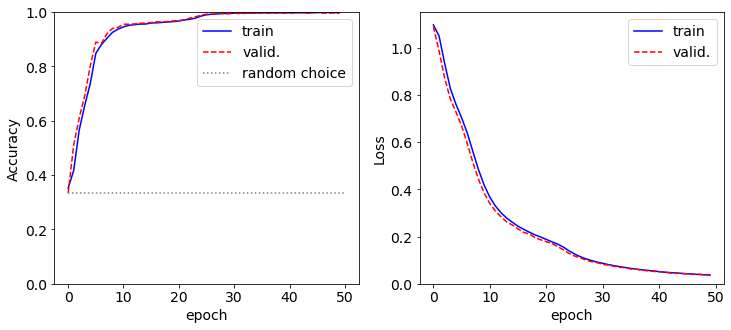

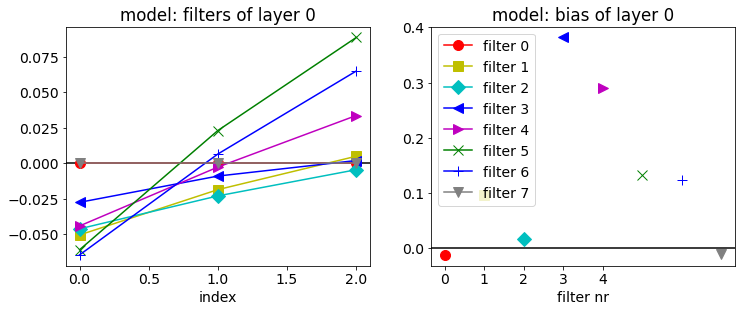

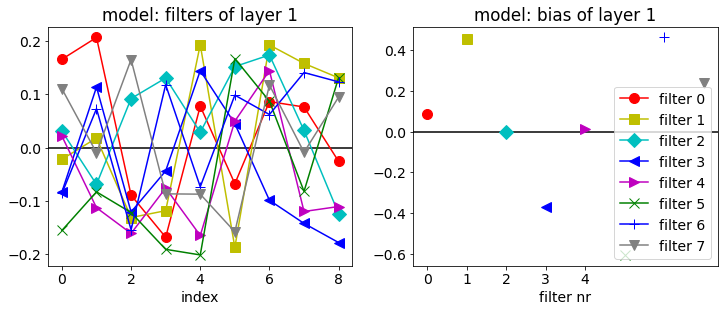

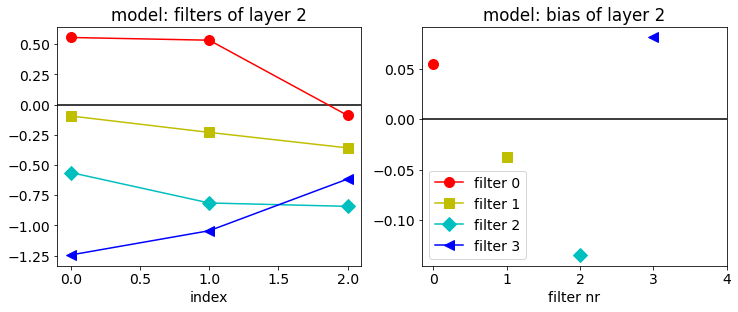

In [ ]:
def Show_history(fit):
    fig,AX = plt.subplots(1,2,figsize=(12,5.))
    ax = AX[0]
    ax.plot(fit.history['accuracy'],"b",label="train")
    ax.plot(fit.history['val_accuracy'],"r--",label="valid.")
    ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray",label="random choice")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0,1])
    ax.legend()
    ax = AX[1]
    ax.plot(fit.history['loss'],"b",label="train")
    ax.plot(fit.history['val_loss'],"r--",label="valid.")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.set_ylim([0,1.05*np.max(fit.history['loss'])])
    ax.legend()
    plt.show()

def Show_weights(model_best_last_year,l=0,label="model"):
    c = ['r','y','c','b','m','g', 'b', 'grey']
    m = ['o','s','D','<','>', 'x', '+', 'v']
    ms = 10
    
    w = model_best_last_year.layers[l].get_weights()[0]
    wT = w.T
    M = len(wT)
    b = model_best_last_year.layers[l].get_weights()[1]
    
    fig,AX = plt.subplots(1,2,figsize=(12,4.4))
    ax = AX[0]
    ax.axhline(0,c="k")
    ax.plot((0,))
    for i in range(M):
        ax.plot(wT[i][0],"-",c=c[i],marker=m[i],label=str(i),markersize=ms)
    ax.set_title(label+': filters of layer '+str(l))
    ax.set_xlabel('index')
    ax = AX[1]
    ax.axhline(0,c="k")
    for i in range(M):
        ax.plot((i),(b[i]),c=c[i],marker=m[i],label="filter "+str(i),markersize=ms)
    ax.set_title(label+': bias of layer '+str(l))
    ax.set_xlabel('filter nr')
    ax.set_xticks(np.arange(5))
    ax.legend()
    plt.show()

Show_history(fit)

Show_weights(model_best_last_year,0)
Show_weights(model_best_last_year,1)
Show_weights(model_best_last_year,2)

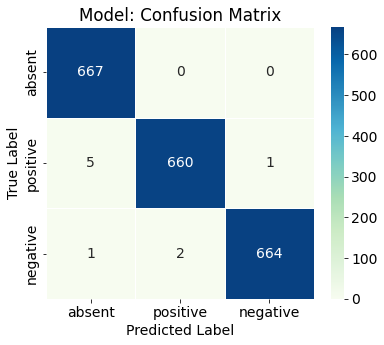

In [ ]:
import pandas as pd
from scipy import stats

import seaborn 
from sklearn import metrics

from sklearn.metrics import classification_report
from sklearn import preprocessing

LABELS = ["absent","positive","negative"]
cmap = "GnBu"

def show_confusion_matrix(validations, predictions, label="Model"):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 5))
    seaborn.heatmap(matrix,
                    xticklabels=LABELS,
                    yticklabels=LABELS,
                    annot=True,
                    fmt='d',
                    linecolor='white',
                    linewidths=1,
                    cmap=cmap)
    plt.title(label+': Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_val = model_best_last_year.predict(x_val)
# take the class with the highest probability from the val predictions
max_y_pred_val = np.argmax(y_pred_val, axis=1)
max_y_val = np.argmax(y_val, axis=1)

show_confusion_matrix(max_y_val, max_y_pred_val)

#print(classification_report(max_y_val, max_y_pred_val))

<a id='exr4_ans'></a>
### Conclusions
The model with the three convolutional layers followed by the global pooling has a very good performance: the accuracy of both training and validation is higher than 99%. It converges in a stable way and in a low number of epochs, even when using small batch sizes. Therefore, the suggested model is successful on a 2-dimensional time series.
This result makes perfect sense: with this structure, the network focuses only on detecting the presence of the pattern, disregarding its position, and the sizes of the filters are adequate for detecting the pattern.

End of file.